### Подготовка датасета 

In [1]:
import os
import cv2
import pandas as pd
from datasets import Dataset, DatasetDict
from PIL import Image
import numpy as np

def load_and_preprocess_data(base_path="data"):
    """
    Улучшенная версия загрузчика данных:
    - Чтение TSV без заголовков
    - Надежная обработка путей
    - Защита от числовых значений в именах файлов
    """
    # Загрузка меток с явным указанием формата
    def load_tsv(filepath):
        df = pd.read_csv(
            filepath,
            sep='\t',
            header=None,
            names=["image_name", "text"],
            dtype={"image_name": str, "text": str}  # Гарантируем строковый тип
        )
        # Очистка от возможных NaN
        df = df.dropna().reset_index(drop=True)
        return df

    # Загрузка данных
    train_labels = load_tsv(os.path.join(base_path, "train.tsv"))
    test_labels = load_tsv(os.path.join(base_path, "test.tsv"))

    # Предобработка изображений с OpenCV
    # ========================================================
    
    def preprocess_image(image_path):
        # Базовые параметры размеров
        img_height = 32  # Фиксированная высота выходного изображения (увеличение улучшает детализацию, но требует больше ресурсов)
        min_width = 100  # Минимальная ширина выходного изображения (меньшие значения обрезают узкие изображения)
        
        try:
            # Загрузка изображения
            img = cv2.imread(image_path)
            if img is None:
                raise ValueError(f"Не удалось загрузить изображение: {image_path}")

            # 1. Анализ исходного размера
            orig_h, orig_w = img.shape[:2]  # Получаем оригинальные размеры
            aspect_ratio = orig_w / orig_h  # Соотношение сторон (чем больше, тем "длиннее" изображение)
            
            # 2. Динамические параметры на основе размера
            scale_factor = max(1, aspect_ratio / 4)  # Коэффициент масштабирования параметров:
                                                    # >1 для широких изображений, =1 для квадратных
                                                    # Увеличение делает обработку более агрессивной для широких изображений

            # 3. Конвейер обработки изображения
            
            # Преобразование в градации серого
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Параметры подавления шума:
            denoise_h = max(3, int(10 / scale_factor))  # Параметр силы подавления шума (h):
                                                    # Большие значения сильнее убирают шум, но могут размыть текст
            denoised = cv2.fastNlMeansDenoising(gray,
                                            h=denoise_h,  # [3-15] Уменьшение убирает шум слабее
                                            templateWindowSize=7,  # [5-9] Размер окна сравнения (нечетное)
                                            searchWindowSize=21)   # [15-25] Область поиска похожих паттернов

            # Адаптивное выравнивание гистограммы (CLAHE)
            clahe_clip = max(1.0, 2.0 / scale_factor)  # Предел контраста [1.0-3.0]:
                                                    # Меньшие значения сохраняют детали в светлых/темных областях
            clahe = cv2.createCLAHE(
                clipLimit=clahe_clip,      # [1.0-3.0] Чем выше, тем контрастнее
                tileGridSize=(8,8))       # Размер сетки [4x4 до 16x16] - меньшие значения дают локальный контраст
            contrast_enhanced = clahe.apply(denoised)

            # Адаптивная бинаризация
            block_size = max(3, int(21 / scale_factor)) | 1  # Размер блока адаптации [3-21] (нечетный):
                                                            # Большие значения лучше для крупного текста
            binary = cv2.adaptiveThreshold(
                contrast_enhanced, 
                255,                       # Максимальное значение
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Метод расчета порога
                cv2.THRESH_BINARY_INV,     # Инвертированный вывод (белый текст на черном)
                block_size,                # Размер области адаптации
                7)                         # Константа C [5-15]: меньшие значения сохраняют больше деталей

            # 4. Удаление артефактов (только для очень широких изображений)
            if aspect_ratio > 5:  # Порог применения [3-8] - регулирует чувствительность к "длинным" изображениям
                kernel_vertical = cv2.getStructuringElement(
                    cv2.MORPH_RECT, 
                    (1, int(15 / scale_factor)))  # Размер ядра вертикального удаления:
                                                # Большие значения удаляют более толстые линии
                vertical_removed = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_vertical)
                binary = cv2.subtract(binary, vertical_removed)

            # 5. Масштабирование с улучшением резкости
            new_w = int(img_height * aspect_ratio)  # Расчет новой ширины с сохранением пропорций
            
            # Интерполяция при масштабировании:
            # INTER_NEAREST - быстро, но грубо
            # INTER_LINEAR - баланс скорости/качества
            # INTER_CUBIC - лучшее качество для уменьшения
            # INTER_LANCZOS4 - наилучшее, но медленно
            resized = cv2.resize(binary, (new_w, img_height), 
                            interpolation=cv2.INTER_CUBIC)
            
            # Увеличение резкости (только для длинных изображений)
            if aspect_ratio > 3:  # Порог применения [2-5]
                kernel_sharp = np.array([  # Ядро повышения резкости:
                    [-1,-1,-1],           # Более сильные значения в центре
                    [-1,9,-1],            # увеличивают резкость, но могут добавить шум
                    [-1,-1,-1]])          # Сумма значений должна быть =1 для сохранения яркости
                resized = cv2.filter2D(resized, -1, kernel_sharp)

            # 6. Адаптивное дополнение
            if new_w < min_width:
                pad_width = min_width - new_w
                resized = np.pad(resized, 
                            ((0,0), (0,pad_width)),  # Дополнение нулями справа
                            mode='constant', 
                            constant_values=0)       # Значение заполнения [0-255]
            else:
                # Дополнительная обработка для очень длинных изображений
                if aspect_ratio > 6:  # Порог [4-8]
                    # Размытие для уменьшения шума
                    resized = cv2.GaussianBlur(resized, 
                                            (3,3),  # Размер ядра [3x3 до 5x5]
                                            0)      # Сигма (0 = авто расчет)
                    
                    # Автоматическая бинаризация по Отсу
                    _, resized = cv2.threshold(
                        resized, 
                        0,                     # Порог (игнорируется для THRESH_OTSU)
                        255,                   # Максимальное значение
                        cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Метод Отсу находит оптимальный порог

            # 7. Нормализация
            normalized = (resized.astype(np.float32) / 255.0)  # Приведение к [0.0-1.0]
            return np.expand_dims(normalized, axis=0)  # Добавление размерности канала (1,H,W)

        except Exception as e:
            print(f"Ошибка обработки {image_path}: {str(e)}")
            return None
    # =========================================================
    # Создание датасета
    def create_dataset(labels_df, images_dir):
        data = {"image": [], "text": []}
        
        for _, row in labels_df.iterrows():
            img_name = str(row["image_name"]).strip()  # На всякий случай очищаем
            img_path = os.path.join(images_dir, img_name)
            
            processed_img = preprocess_image(img_path)
            if processed_img is not None:
                data["image"].append(processed_img)
                data["text"].append(str(row["text"]).strip())
        
        return Dataset.from_dict(data)

    # Сборка итогового датасета
    return DatasetDict({
        "train": create_dataset(train_labels, os.path.join(base_path, "train")),
        "test": create_dataset(test_labels, os.path.join(base_path, "test"))
    })

# Проверка работы
try:
    dataset = load_and_preprocess_data()
    print(f"Успешно загружено {len(dataset['train'])} тренировочных и {len(dataset['test'])} тестовых примеров")
    print("Пример данных:", dataset["test"][0])
except Exception as e:
    print(f"Критическая ошибка: {str(e)}")


Успешно загружено 72284 тренировочных и 1544 тестовых примеров
Пример данных: {'image': [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

### Вывод примеров для оценки качества предобработки

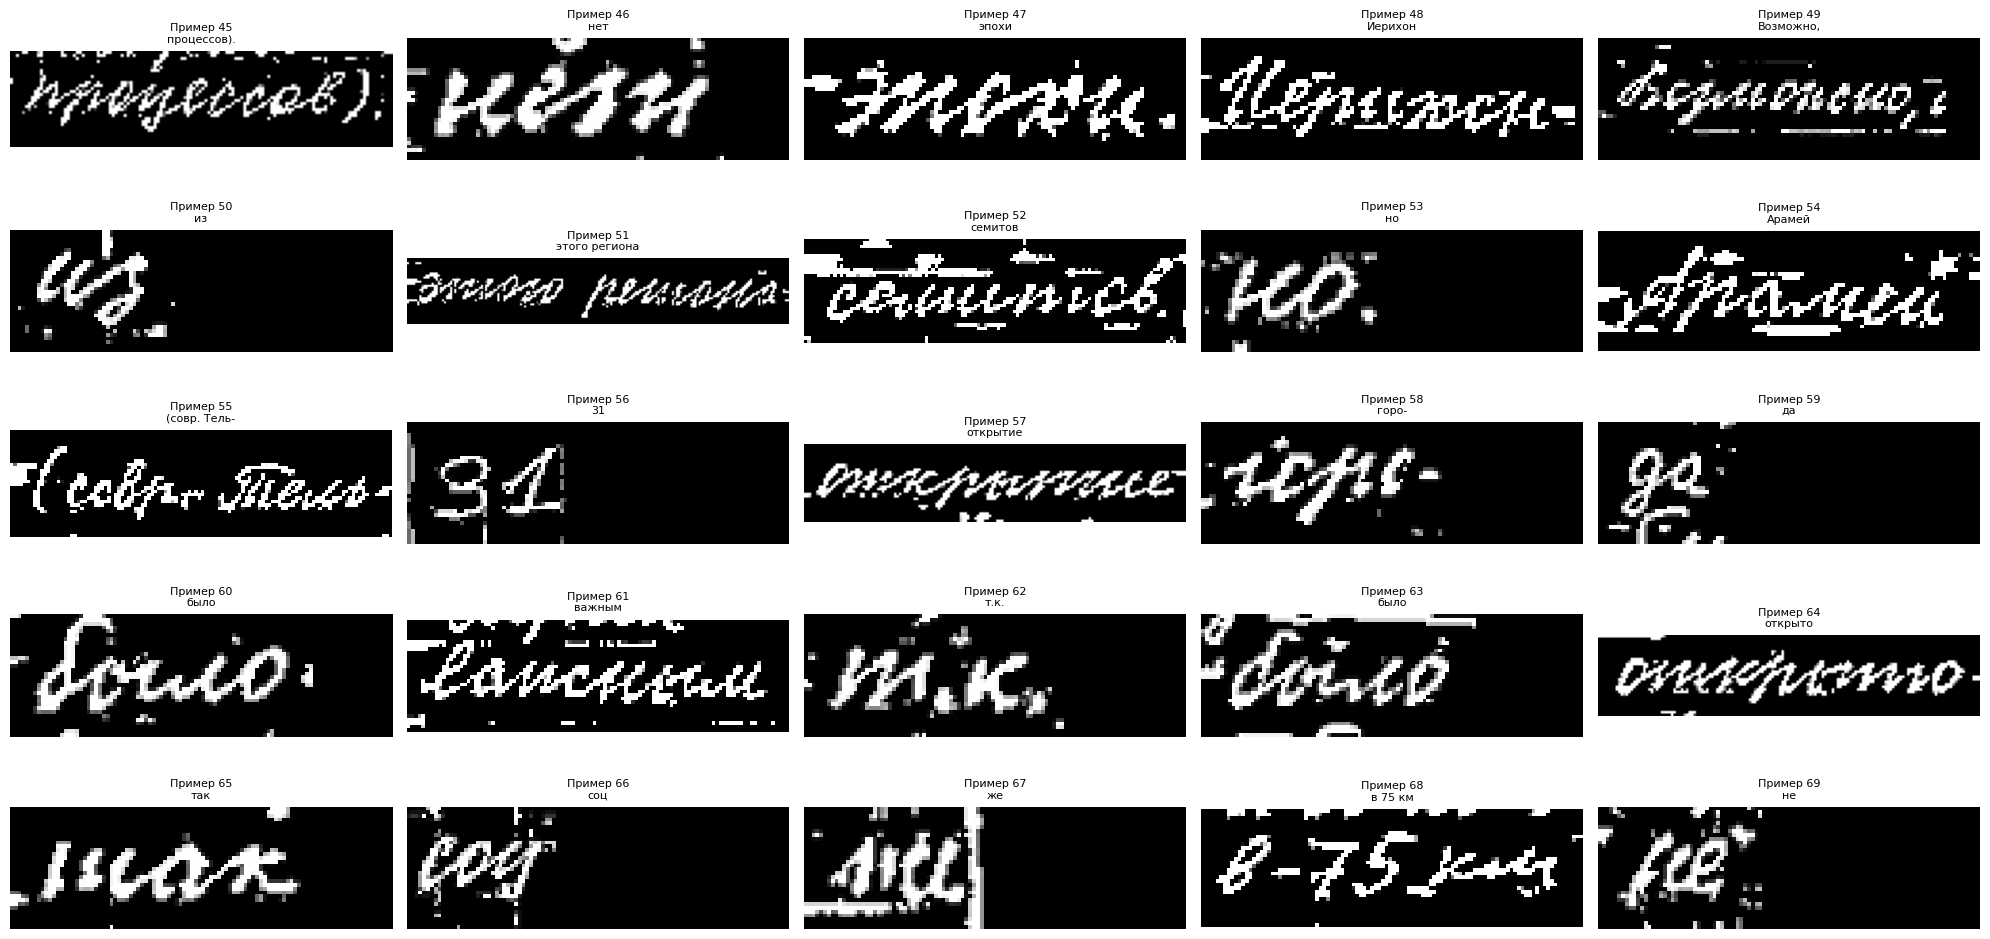

In [2]:
import matplotlib.pyplot as plt
import math

def show_dataset_samples(dataset, split="train", num_samples=10, start_index=0, 
                        samples_per_row=5, figsize=(20, 10)):
    """
    Визуализирует примеры из датасета в табличном формате
    
    Параметры:
    - dataset: загруженный датасет (DatasetDict)
    - split: раздел датасета ("train" или "test")
    - num_samples: общее количество примеров для отображения
    - start_index: начальный индекс для отображения (по умолчанию 0)
    - samples_per_row: количество примеров в одной строке (по умолчанию 5)
    - figsize: размер фигуры matplotlib (ширина, высота)
    """
    # Рассчитываем количество строк
    num_rows = math.ceil(num_samples / samples_per_row)
    
    # Создаем фигуру с правильным соотношением сторон
    plt.figure(figsize=figsize)
    
    for i in range(num_samples):
        # Получаем текущий индекс с учетом смещения
        current_idx = start_index + i
        
        # Проверяем, не вышли ли за пределы датасета
        if current_idx >= len(dataset[split]):
            break
            
        sample = dataset[split][current_idx]
        image = sample["image"][0]  # Получаем первый (и единственный) канал
        text = sample["text"]
        
        # Создаем подграфик с правильным позиционированием
        plt.subplot(num_rows, samples_per_row, i+1)
        plt.imshow(image, cmap='gray')
        
        # Форматируем заголовок (перенос строки каждые 50 символов)
        formatted_text = '\n'.join([text[j:j+50] for j in range(0, len(text), 50)])
        plt.title(f"Пример {current_idx}\n{formatted_text}", fontsize=8)
        plt.axis('off')
        
        # =========
        # =========
    
    plt.tight_layout()
    plt.show()

# Пример использования:
# Показать 10 примеров начиная с индекса 5, по 5 в строке
show_dataset_samples(dataset, split="train", num_samples=25, start_index=45, samples_per_row=5)

# Показать 15 примеров начиная с индекса 10, по 3 в строке
# show_dataset_samples(dataset, split="test", num_samples=15, start_index=10, samples_per_row=3)

### Класс ImageTextDataset

In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset as TorchDataset
import os

class ImageTextDataset(TorchDataset):
    def __init__(self, data):
        self.data = data
        # Находим максимальную ширину во всем датасете
        self.max_width = max(np.array(sample['image']).shape[2] for sample in data)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        # Конвертируем в numpy array и убираем лишние размерности
        img = np.array(sample['image']).squeeze()
        text = sample['text']
        
        # Дополняем изображение до максимальной ширины
        pad_width = self.max_width - img.shape[1]
        if pad_width > 0:
            img = np.pad(img, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
            
        return {
            'image': torch.from_numpy(img).unsqueeze(0).float(),  # Добавляем размерность канала
            'text': text
        }

def save_datasets(dataset_dict, save_dir="preprocessed_data"):
    """Сохраняет датасеты в формате HuggingFace"""
    os.makedirs(save_dir, exist_ok=True)
    
    for split in dataset_dict.keys():
        # Сохраняем в родном формате HuggingFace
        dataset_dict[split].save_to_disk(os.path.join(save_dir, split))
    
    print(f"Датасеты сохранены в {save_dir}")

def load_datasets(save_dir="preprocessed_data"):
    """Загружает датасеты из сохраненного формата"""
    from datasets import DatasetDict, load_from_disk
    
    datasets = {}
    
    for split in ['train', 'test']:
        split_dir = os.path.join(save_dir, split)
        if os.path.exists(split_dir):
            datasets[split] = load_from_disk(split_dir)
    
    # Конвертируем в PyTorch Dataset
    torch_datasets = {
        split: ImageTextDataset(datasets[split])
        for split in datasets.keys()
    }
    
    print(f"Загружено {len(torch_datasets.get('train', []))} train и {len(torch_datasets.get('test', []))} test примеров")
    return torch_datasets

def collate_fn(batch):
    """Обрабатывает батчи с изображениями разного размера"""
    max_width = max(item['image'].shape[2] for item in batch)
    
    images = []
    texts = []
    for item in batch:
        img = item['image']
        pad = max_width - img.shape[2]
        if pad > 0:
            img = torch.nn.functional.pad(img, (0, pad))
        images.append(img)
        texts.append(item['text'])
    
    return {
        'image': torch.stack(images),
        'text': texts
    }

### Сохранение датасета

In [18]:
save_datasets(dataset)

Saving the dataset (0/3 shards):   0%|          | 0/72284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1544 [00:00<?, ? examples/s]

Датасеты сохранены в preprocessed_data


### Проверка загрузки датасета

Загружено 72284 train и 1544 test примеров
Первые 5 изображений в датасете:


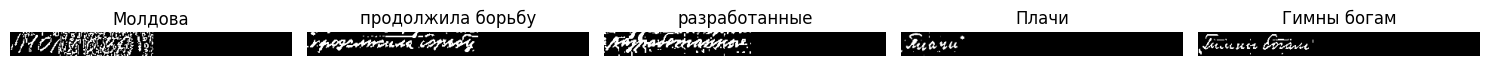


Информация о первом батче:
Размерность батча изображений: torch.Size([16, 1, 32, 374])
Количество текстов в батче: 16
Пример текста: примере
Максимальная ширина в батче: 374

Первые 5 изображений из батча:


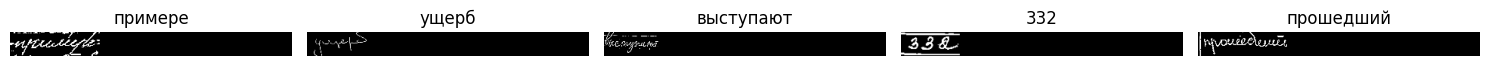

In [23]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Загрузка данных
torch_datasets = load_datasets()

# Создание DataLoader
train_loader = DataLoader(
    torch_datasets['train'],
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)

# 1. Вывод первых 5 отдельных изображений до батчинга
print("Первые 5 изображений в датасете:")
plt.figure(figsize=(15, 5))
for i in range(5):
    sample = torch_datasets['train'][i]
    img = sample['image'].squeeze().numpy()  # Убираем размерность канала для отображения
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Img {i}\n{sample['text'][:30]}..." if len(sample['text']) > 30 else sample['text'])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Получение и вывод информации о первом батче
print("\nИнформация о первом батче:")
batch = next(iter(train_loader))
images, texts = batch['image'], batch['text']

print(f"Размерность батча изображений: {images.shape}")  # [batch_size, 1, height, max_width]
print(f"Количество текстов в батче: {len(texts)}")
print(f"Пример текста: {texts[0]}")
print(f"Максимальная ширина в батче: {images.shape[3]}")

# 3. Визуализация изображений из батча
print("\nПервые 5 изображений из батча:")
plt.figure(figsize=(15, 5))
for i in range(5):
    img = images[i].squeeze().numpy()  # [1, H, W] -> [H, W]
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Batch {i}\n{texts[i][:30]}..." if len(texts[i]) > 30 else texts[i])
    plt.axis('off')
plt.tight_layout()
plt.show()